In [1]:
## Calculate and save selected properties in different parameter cases
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os, sys
sys.path.append(os.path.abspath('./TEF'))
import TEF_Variables as tef

In [2]:
# Obtain reflux coefficients and entrainment flux Qe
def reflux(Qsg, hs, xi):

    State = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(Qsg,'03d')) + '_tide003/state_' + str(format(hs,'03d')) + '.nc')
    Grid = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(Qsg,'03d')) + '_tide003/grid_' + str(format(hs,'03d')) + '.nc')
    # Confine to the range of fjord
    state = State.isel(X=range(120), Xp1=range(121), Y=range(30,39), T=range(1,len(State.T)))
    grid = Grid.isel(X=range(120), Xp1=range(121), Y=range(30,39))


    s = state.S.data.mean(2) # Salinity in T,Z,X
    u = (state.U.data[:,:,:,1:].mean(2) + state.U.data[:,:,:,:-1].mean(2)) / 2 # Along channel velocity
    ot = state.T.data # Time in seconds


    HFacC1 = grid.HFacC.data.mean(1)
    dyF1 = grid.dyF.data.mean(0)
    drF1 = grid.drF.data
    gridA = np.broadcast_to(drF1[:, np.newaxis], HFacC1.shape) * np.broadcast_to(dyF1[np.newaxis, :], HFacC1.shape) * HFacC1 # Grid Area
    da = np.broadcast_to(gridA[np.newaxis,:,:], u.shape)

    S = state.S.data
    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC
    
    
    Qin = np.empty(len(xi))
    Qout = np.empty(len(xi))
    Sin = np.empty(len(xi))
    Sout = np.empty(len(xi))
    t0 = 89 # 274
    
    for i in range(len(xi)):
    
        tef_q1, tef_vel1, tef_da1, tef_qs1, tef_qs21, sbins1 = tef.process_section(U,S,DA,ot,xi[i],23,testing=False)

        qin1, qout1, sin1, sout1 = tef.bulk_calc(tef_q1, tef_vel1, tef_da1, tef_qs1, tef_qs21, sbins1, ot)
    
        Qin[i] = qin1[t0:].mean() # Time averaging from 1+t0 hour
        Qout[i] = qout1[t0:].mean()
        Sin[i] = sin1[t0:].mean() # Time averaging from 1+t0 hour
        Sout[i] = sout1[t0:].mean()
        
    a002 = (Sin[0]/Sout[0])*(Sout[1]-Sout[0])/(Sout[1]-Sin[0])
    a001 = (Qin[0]-Qin[1]) / Qin[0]    
    a11 = (Sout[1]/Sin[1])*(Sin[1]-Sin[0])/(Sout[1]-Sin[0])    
    a01 = (Sout[1]/Sout[0])*(Sout[0]-Sin[0])/(Sout[1]-Sin[0])
    
    a10 = (Sin[0]/Sin[1])*(Sout[1]-Sin[1])/(Sout[1]-Sin[0])
    
    #a00 = -(Qout[0]/Qin[0])*(Sout[1]-Sout[0])/(Sout[1]-Sin[0])
    #a11 = -(Qin[1]/Qout[1])*(Sin[1]-Sin[0])/(Sout[1]-Sin[0])
    #a01 = (Qin[1]/Qin[0])*(Sout[1]-Sin[1])/(Sout[1]-Sin[0])
    #a10 = (Qout[0]/Qout[1])*(Sout[0]-Sin[0])/(Sout[1]-Sin[0])
    
    q0 = Qin[0]
    q1 = -Qout[-1]
    Q0 = -Qout[0]
    Q1 = Qin[-1]
    f0 = Sin[0]*q0
    f1 = Sout[-1]*q1
    F0 = Sout[0]*Q0
    F1 = Sin[-1]*Q1
    
    A = np.array([[q1, q0, 0, 0], [f1, f0, 0, 0], [0, 0, q1, q0], [0, 0, f1, f0]])
    B = np.array([Q1, F1, Q0, F0])
    X = np.linalg.solve(A,B) # a11, a01, a10, a00
    
    Qe = Q0 - q1
    
    return X[0],X[-1],q1,q0,Q1,Q0

In [3]:
def vol_temp(Qsg, hs, xi):
    
    State = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(Qsg,'03d')) + '_tide003/state_' + str(format(hs,'03d')) + '.nc')
    Grid = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(Qsg,'03d')) + '_tide003/grid_' + str(format(hs,'03d')) + '.nc')
    # Confine to the range of fjord
    state = State.isel(X=range(120), Xp1=range(121), Y=range(30,39), T=range(1,len(State.T)))
    grid = Grid.isel(X=range(120), Xp1=range(121), Y=range(30,39))

    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2 # Along-channel velocity
    
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC
    
    rA = np.broadcast_to(grid.rA.data[np.newaxis, np.newaxis, :, :], U.shape)
    CV = rA * drF * HFacC

    
    t0 = 89 # 274
    da = DA[t0:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    cv = CV[t0:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    s = state.S.data[t0:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    temp = state.Temp.data[t0:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    u = U[t0:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    sma = np.ma.masked_where(s==0, s)
    topo = np.ma.getmask(sma) # Masked Topography
    uma = np.ma.MaskedArray(u, mask=topo)
    tma = np.ma.MaskedArray(temp, mask=topo)
    
    
    Tv1 = np.empty(uma.shape[1])
    Tv2 = np.empty(uma.shape[1])
    Vol1 = np.empty(uma.shape[1])
    Vol2 = np.empty(uma.shape[1])
    Tvol1 = np.empty(uma.shape[1])
    Tvol2 = np.empty(uma.shape[1])
    L = np.empty(uma.shape[1])
    
    for i in range(uma.shape[1]):
            
        if any(uma[:,i]<0)==False:
            pass
            
        else:
            l = np.where(uma[:,i] < 0)[-1][0]    
            Tv1[i] = np.sum(tma[:l,i]*da[:l,i]*uma[:l,i]) / np.sum(da[:l,i]*uma[:l,i])
            Tv2[i] = np.sum(tma[l:,i]*da[l:,i]*uma[l:,i]) / np.sum(da[l:,i]*uma[l:,i])
            Vol1[i] = cv[:l,i].sum()
            Vol2[i] = cv[l:,i].sum()
            Tvol1[i] = np.sum(tma[:l,i]*cv[:l,i])
            Tvol2[i] = np.sum(tma[l:,i]*cv[l:,i])
            L[i] = l
            
        Tf = Tv1[:-1].mean()
        Ts = Tv2[:-1].mean()
        #Tf = Tvol1[:-1].sum()/Vol1[:-1].sum()
        #Ts = Tvol2[:-1].sum()/Vol2[:-1].sum()
        Ts_in = Tv2[-1]
        
    return Tf, Ts, Ts_in
    #return L

In [4]:
# Obtain submarine melting Qsm
def IFA(Qsg,hs):
    # Grid areas
    Area = np.empty([50, 9])
    Area[:10,:] = 100
    Area[10:20,:] = 200
    Area[20:30,:] = 300
    Area[30:40,:] = 800
    Area[40:,:] = 1600
    file = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg' + str(format(Qsg,'03d')) + '_tide003/icefrntA_' + str(format(hs,'03d')) + '.nc')
    t0 = 89
    tn = len(file.T)
    state = file.isel(Y=range(30,39), T=range(t0,tn))
    MR = state.icefrntA.isel(X=1).data.mean(0) # Melt rate at the icefront
    Qsm = (MR*Area).sum()/(24*3600)
    return Qsm

In [5]:
qsg = 500
hs = np.array([1,2,3,4,5])
hsr = np.array([0.04,0.06,0.08,0.10,0.12])
xrange1 = np.array([5,47]) # X index range for the fjord interior
xrange2 = np.array([47,97]) # X index range for the sill segment


alp11_1 = np.empty(len(hs))
alp00_1 = np.empty(len(hs))
Qin0_1 = np.empty(len(hs))
Qin1_1 = np.empty(len(hs))
Qout0_1 = np.empty(len(hs))
Ts_1 = np.empty(len(hs))
Tf_1 = np.empty(len(hs))
Ts_in_1 = np.empty(len(hs))

alp11_2 = np.empty(len(hs))
alp00_2 = np.empty(len(hs))
Qin0_2 = np.empty(len(hs))
Qin1_2 = np.empty(len(hs))
Qout0_2 = np.empty(len(hs))
Ts_2 = np.empty(len(hs))
Tf_2 = np.empty(len(hs))
Ts_in_2 = np.empty(len(hs))

Qsm = np.empty(len(hs))

for j in range(len(hs)):
    alp11_1[j], alp00_1[j], Qin1_1[j], Qin0_1[j], Qout1_1, Qout0_1[j] = reflux(qsg,hs[j],xrange1)
    Tf_1[j], Ts_1[j], Ts_in_1[j] = vol_temp(qsg,hs[j],xrange1)
    
    alp11_2[j], alp00_2[j], Qin1_2[j], Qin0_2[j], Qout1_2, Qout0_2[j] = reflux(qsg,hs[j],xrange2)
    Tf_2[j], Ts_2[j], Ts_in_2[j] = vol_temp(qsg,hs[j],xrange2)
    
    Qsm[j] = IFA(qsg, hs[j])

# Ts inside fjord
Tse_1 = (Ts_in_1*Qin1_1*(1-alp11_1) + Tf_1*Qin0_1*alp00_1) / Qout0_1

# Ts at sill
Tse_2 = (Ts_in_2*Qin1_2*(1-alp11_2) + Tf_2*Qin0_2*alp00_2) / Qout0_2

Qe = Qout0_2 - Qin1_2

  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120
  time 0 out of 120


In [6]:
#alp11_1.shape, Qe.shape, Tse_1.shape
#Tf_1, Tf_2, Qin0_1, Qin0_2
#ll = vol_temp(qsg, 5, xrange1)
#ll

In [7]:
# Save outputs
#Cd = np.array([0, 1.25e-3, 2.5e-3, 2.5e-2])

TEF_ds = xr.Dataset(
    data_vars={'hsr' : hsr,
    'alpha11' : alp11_2,
    'alpha00' : alp00_2,
    'Qe' : Qe,
    'Ts_fjord' : Tse_1,
    'Ts_sill' : Tse_2,
    'Qsm' : Qsm})

#outdir = "/Volumes/Extreme SSD/MITgcm outputs/Qsg_comp/"
#outdir = "/Volumes/Extreme SSD/MITgcm outputs/Strat_comp/"
#outdir = "/Volumes/Extreme SSD/MITgcm outputs/Cd_comp/"
outdir = "/Volumes/Extreme SSD/MITgcm outputs/Tide_comp/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

#TEF_ds.to_netcdf(outdir + 'Qsg_' + str(format(qsg,'04d')) + '.nc')
#TEF_ds.to_netcdf(outdir + 'Cd_004.nc')
TEF_ds.to_netcdf(outdir + 'Tide_003.nc')


In [ ]:
# Quicklook of the output/input file
h = 500

file = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg_comp/Qsg_' + str(format(h,'04d')) + '.nc')

file

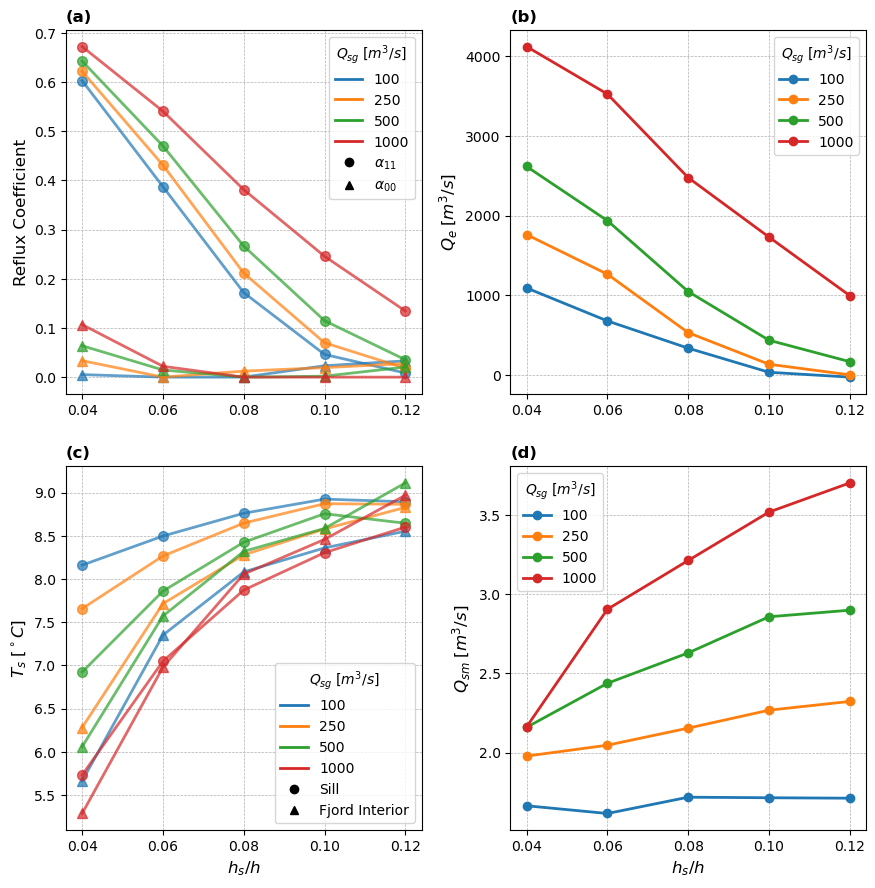

In [9]:
# 1_Plot for Qsg cases
Qsg = np.array([100, 250, 500, 1000])

fig1 = plt.figure(figsize=(10,10))
#fig1.tight_layout()
#plt.grid(linestyle='--', linewidth=0.5)    
ax1 = fig1.add_subplot(221)
ax2 = fig1.add_subplot(222)
ax3 = fig1.add_subplot(223)
ax4 = fig1.add_subplot(224)


from matplotlib.legend_handler import HandlerBase


# class AnyObjectHandler(HandlerBase):
#     def create_artists(self, legend, orig_handle,
#                        x0, y0, width, height, fontsize, trans):
#         l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
#                            linestyle=orig_handle[1],color=orig_handle[0])
#         l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
#                            color=orig_handle[0])
#         return [l1, l2]
    



for i in range(len(Qsg)):
    
    file1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg_comp/Qsg_' + str(format(Qsg[i],'04d')) + '.nc')
    hsr = file1.hsr.data
    alp11 = file1.alpha11.data
    alp11[alp11<0] = 0
    alp00 = file1.alpha00.data
    Ts_f = file1.Ts_fjord.data
    Ts_s = file1.Ts_sill.data
    Qsm = file1.Qsm.data   
    Qe = file1.Qe.data

    # Subplot of reflux coefficients
    if Qsg[i] == 100:
        l1,l2 = ax1.plot(hsr,alp00,'o-', hsr,alp11,'^-', ms=7, alpha=0.7, color='#1f77b4',lw=2)
    #ax1.set_ylim(0,.7)
        
    elif Qsg[i] == 250:
        
        l3,l4 = ax1.plot(hsr,alp00,'o-',hsr,alp11,'^-', ms=7, alpha=0.7, color='#ff7f0e',lw=2)
        
    elif Qsg[i] == 500:
        
        l5,l6 = ax1.plot(hsr,alp00,'o-',hsr,alp11,'^-', ms=7, alpha=0.7, color='#2ca02c',lw=2)
    
    else:
        
        l7,l8 = ax1.plot(hsr,alp00,'o-',hsr,alp11,'^-', ms=7, alpha=0.7, color='#d62728',lw=2)
    
#     ax1.legend((l1,l2,l3,l4,l5,l6,l7,l8),('100 $T_S$','100 $T_S2$','250 $T_S1$','250 $T_S2$','500 $T_S1$','500 $T_S2$','1000 $T_S1$','1000 $T_S2$'),
#                title=r'$Q_{sg}\;[m^3/s]$', loc='best', fontsize=12)



#     #Plot analytic solution
#     ax1.plot(hsr,alp11,'o-',lw=2,label=str(Qsg[i]))

#     #Plot simulation
#     ax1.plot(hsr,alp00,'^-',lw=2,label=str(Qsg[i]))

    
#     #Get artists and labels for legend and chose which ones to display
#     handles, labels = ax1.get_legend_handles_labels()
#     display = (0,1,2,3,4)

#     #Create custom artists
    
#     simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
#     anyArtist = plt.Line2D((0,1),(0,0), color='k', marker='^', linestyle='')

#     #Create legend from custom artist/label lists
#     ax1.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
#           [label for i,label in enumerate(labels) if i in display]+['Simulation', 'Analytic'], title=r'$Q_{sg}\;[m^3/s]$',loc='best', fontsize=12)
    
    #line = Line2D([0,1],[0,1],linestyle='-', color='r')
    line1 = plt.Line2D((0,1),(0,0), color='#1f77b4', lw=2, linestyle='-')
    line2 = plt.Line2D((0,1),(0,0), color='#ff7f0e', lw=2, linestyle='-')
    line3 = plt.Line2D((0,1),(0,0), color='#2ca02c', lw=2, linestyle='-')
    line4 = plt.Line2D((0,1),(0,0), color='#d62728', lw=2, linestyle='-')
    marker1 = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
    marker2 = plt.Line2D((0,1),(0,0), color='k', marker='^', linestyle='')    
    
    ax1.legend([line1,line2,line3,line4,marker1,marker2],['100','250','500','1000',r'$\alpha_{11}$', r'$\alpha_{00}$'],
              title=r'$Q_{sg}\;[m^3/s]$',loc='best', fontsize=10)

    ax1.grid(linestyle='--', linewidth=0.5)
    ax1.set_ylabel(r'Reflux Coefficient',size = 12)
    #ax1.xaxis.set_visible(False)
    ax1.set_title(r'(a)', loc='left', size=12, weight='bold')

    
    # Subplot of entrainment flux Qe
    ax2.plot(hsr,Qe,'o-',lw=2,label=str(Qsg[i]))
    #ax2.set_ylim(0,4500)
    ax2.legend(title=r'$Q_{sg}\;[m^3/s]$',loc='best', fontsize=10)
    ax2.grid(linestyle='--', linewidth=0.5)
    ax2.set_ylabel(r'$Q_e\;[m^3/s]$',size = 12)
    #ax2.xaxis.set_visible(False)
    ax2.set_title(r'(b)', loc='left', size=12, weight='bold')
       
    
    # Subplot of deep-layer temperature Ts
    if Qsg[i] == 100:
           
        ax3.plot(hsr,Ts_s,'o-', hsr,Ts_f,'^-', ms=7, alpha=0.7, color='#1f77b4',lw=2)
    #ax1.set_ylim(0,.7)
        
    elif Qsg[i] == 250:
        
        ax3.plot(hsr,Ts_s,'o-',hsr,Ts_f,'^-', ms=7, alpha=0.7, color='#ff7f0e',lw=2)
        
    elif Qsg[i] == 500:
        
        ax3.plot(hsr,Ts_s,'o-',hsr,Ts_f,'^-', ms=7, alpha=0.7, color='#2ca02c',lw=2)
    
    else:
        
        ax3.plot(hsr,Ts_s,'o-',hsr,Ts_f,'^-', ms=7, alpha=0.7, color='#d62728',lw=2)   
    
#     ax3.plot(hsr,Ts_s,'o-',lw=2,label=r'$Q_{sg}$')
#     ax3.plot(hsr,Ts_f,'^-',lw=2,label=r'$Q_{sg}$')

    #ax3.set_ylim(0,.7)
    #ax3.legend(loc='best', fontsize=12)
    ax3.legend([line1,line2,line3,line4,marker1,marker2],['100','250','500','1000','Sill', 'Fjord Interior'],
              title=r'$Q_{sg}\;[m^3/s]$',loc='best', fontsize=10)
    
    ax3.grid(linestyle='--', linewidth=0.5)
    ax3.set_ylabel(r'$T_s\;[^\circ{C}]$',size = 12)
    ax3.set_xlabel(r'$h_s/h$', size = 12)
    ax3.set_title(r'(c)', loc='left', size=12, weight='bold')    
    
    
    # Subplot of submarine melting Qsm
    ax4.plot(hsr,Qsm,'o-',lw=2,label=str(Qsg[i]))
    #ax4.set_ylim(0,4500)
    ax4.legend(title=r'$Q_{sg}\;[m^3/s]$',loc='best', fontsize=10)
    ax4.grid(linestyle='--', linewidth=0.5)
    ax4.set_ylabel(r'$Q_{sm}\;[m^3/s]$',size = 12)
    ax4.set_xlabel(r'$h_s/h$', size = 12)
    ax4.set_title(r'(d)', loc='left', size=12, weight='bold')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.2)
plt.show()

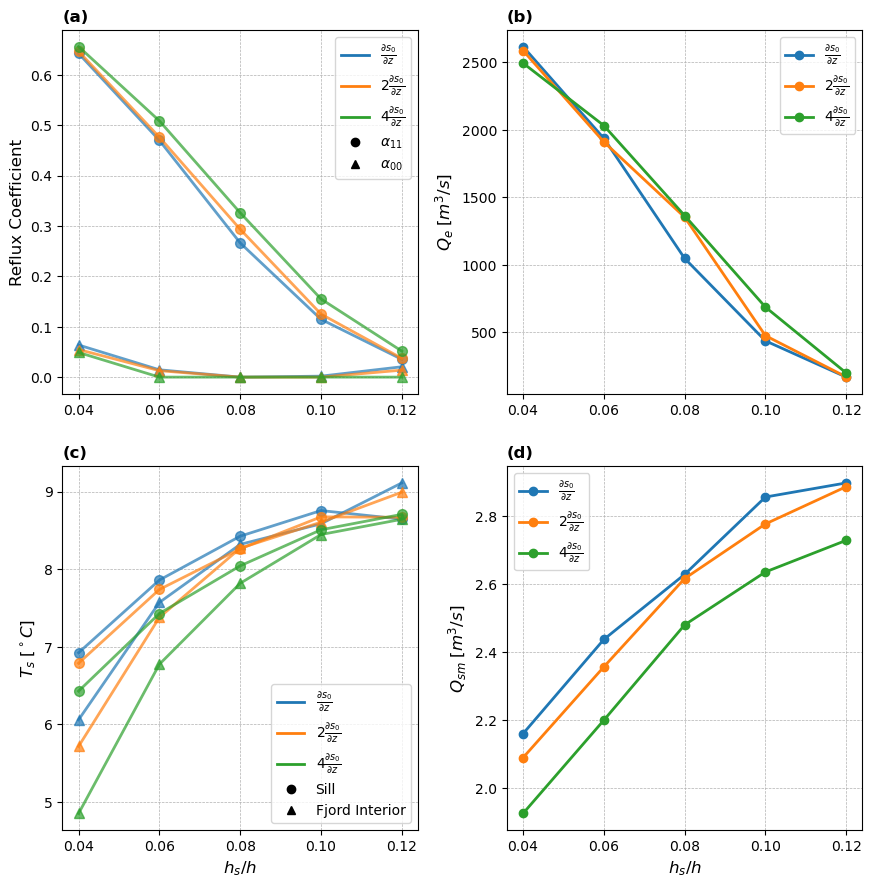

In [7]:
# 2_Plot for Stratification cases
Strat = np.array([1, 2, 3])
Sz = [r'$\frac{\partial s_0}{\partial z}$', r'$2\frac{\partial s_0}{\partial z}$', r'$4\frac{\partial s_0}{\partial z}$']

fig2 = plt.figure(figsize=(10,10))
#fig1.tight_layout()
#plt.grid(linestyle='--', linewidth=0.5)    
ax1 = fig2.add_subplot(221)
ax2 = fig2.add_subplot(222)
ax3 = fig2.add_subplot(223)
ax4 = fig2.add_subplot(224)


from matplotlib.legend_handler import HandlerBase


# class AnyObjectHandler(HandlerBase):
#     def create_artists(self, legend, orig_handle,
#                        x0, y0, width, height, fontsize, trans):
#         l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
#                            linestyle=orig_handle[1],color=orig_handle[0])
#         l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
#                            color=orig_handle[0])
#         return [l1, l2]
    



for i in range(len(Strat)):
    
    file1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Strat_comp/Strat_' + str(format(Strat[i],'03d')) + '.nc')
    hsr = file1.hsr.data
    alp11 = file1.alpha11.data
    alp11[alp11<0] = 0
    alp00 = file1.alpha00.data
    Ts_f = file1.Ts_fjord.data
    Ts_s = file1.Ts_sill.data
    Qsm = file1.Qsm.data   
    Qe = file1.Qe.data

    # Subplot of reflux coefficients
    if Strat[i] == 1:
        l1,l2 = ax1.plot(hsr,alp00,'o-', hsr,alp11,'^-', ms=7, alpha=0.7, color='#1f77b4',lw=2)
    #ax1.set_ylim(0,.7)
        
    elif Strat[i] == 2:
        
        l3,l4 = ax1.plot(hsr,alp00,'o-',hsr,alp11,'^-', ms=7, alpha=0.7, color='#ff7f0e',lw=2)
        
    elif Strat[i] == 3:
        
        l5,l6 = ax1.plot(hsr,alp00,'o-',hsr,alp11,'^-', ms=7, alpha=0.7, color='#2ca02c',lw=2)
    
    else:
        
        l7,l8 = ax1.plot(hsr,alp00,'o-',hsr,alp11,'^-', ms=7, alpha=0.7, color='#d62728',lw=2)
    
#     ax1.legend((l1,l2,l3,l4,l5,l6,l7,l8),('100 $T_S$','100 $T_S2$','250 $T_S1$','250 $T_S2$','500 $T_S1$','500 $T_S2$','1000 $T_S1$','1000 $T_S2$'),
#                title=r'$Q_{sg}\;[m^3/s]$', loc='best', fontsize=12)



#     #Plot analytic solution
#     ax1.plot(hsr,alp11,'o-',lw=2,label=str(Qsg[i]))

#     #Plot simulation
#     ax1.plot(hsr,alp00,'^-',lw=2,label=str(Qsg[i]))

    
#     #Get artists and labels for legend and chose which ones to display
#     handles, labels = ax1.get_legend_handles_labels()
#     display = (0,1,2,3,4)

#     #Create custom artists
    
#     simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
#     anyArtist = plt.Line2D((0,1),(0,0), color='k', marker='^', linestyle='')

#     #Create legend from custom artist/label lists
#     ax1.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
#           [label for i,label in enumerate(labels) if i in display]+['Simulation', 'Analytic'], title=r'$Q_{sg}\;[m^3/s]$',loc='best', fontsize=12)
    
    #line = Line2D([0,1],[0,1],linestyle='-', color='r')
    line1 = plt.Line2D((0,1),(0,0), color='#1f77b4', lw=2, linestyle='-')
    line2 = plt.Line2D((0,1),(0,0), color='#ff7f0e', lw=2, linestyle='-')
    line3 = plt.Line2D((0,1),(0,0), color='#2ca02c', lw=2, linestyle='-')
    line4 = plt.Line2D((0,1),(0,0), color='#d62728', lw=2, linestyle='-')
    marker1 = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
    marker2 = plt.Line2D((0,1),(0,0), color='k', marker='^', linestyle='')    
    
    ax1.legend([line1,line2,line3,marker1,marker2],[r'$\frac{\partial s_0}{\partial z}$',r'$2\frac{\partial s_0}{\partial z}$',r'$4\frac{\partial s_0}{\partial z}$',r'$\alpha_{11}$', r'$\alpha_{00}$'],
              loc='best', fontsize=10)

    ax1.grid(linestyle='--', linewidth=0.5)
    ax1.set_ylabel(r'Reflux Coefficient',size = 12)
    #ax1.xaxis.set_visible(False)
    ax1.set_title(r'(a)', loc='left', size=12, weight='bold')

    
    # Subplot of entrainment flux Qe
    ax2.plot(hsr,Qe,'o-',lw=2,label=Sz[i])
    #ax2.set_ylim(0,4500)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(linestyle='--', linewidth=0.5)
    ax2.set_ylabel(r'$Q_e\;[m^3/s]$',size = 12)
    #ax2.xaxis.set_visible(False)
    ax2.set_title(r'(b)', loc='left', size=12, weight='bold')
       
    
    # Subplot of deep-layer temperature Ts
    if Strat[i] == 1:
           
        ax3.plot(hsr,Ts_s,'o-', hsr,Ts_f,'^-', ms=7, alpha=0.7, color='#1f77b4',lw=2)
    #ax1.set_ylim(0,.7)
        
    elif Strat[i] == 2:
        
        ax3.plot(hsr,Ts_s,'o-',hsr,Ts_f,'^-', ms=7, alpha=0.7, color='#ff7f0e',lw=2)
        
    elif Strat[i] == 3:
        
        ax3.plot(hsr,Ts_s,'o-',hsr,Ts_f,'^-', ms=7, alpha=0.7, color='#2ca02c',lw=2)
    
    else:
        
        ax3.plot(hsr,Ts_s,'o-',hsr,Ts_f,'^-', ms=7, alpha=0.7, color='#d62728',lw=2)   
    
#     ax3.plot(hsr,Ts_s,'o-',lw=2,label=r'$Q_{sg}$')
#     ax3.plot(hsr,Ts_f,'^-',lw=2,label=r'$Q_{sg}$')

    #ax3.set_ylim(0,.7)
    #ax3.legend(loc='best', fontsize=12)
    ax3.legend([line1,line2,line3,marker1,marker2],[r'$\frac{\partial s_0}{\partial z}$',r'$2\frac{\partial s_0}{\partial z}$',r'$4\frac{\partial s_0}{\partial z}$','Sill', 'Fjord Interior'],
              loc='best', fontsize=10)
    
    ax3.grid(linestyle='--', linewidth=0.5)
    ax3.set_ylabel(r'$T_s\;[^\circ{C}]$',size = 12)
    ax3.set_xlabel(r'$h_s/h$', size = 12)
    ax3.set_title(r'(c)', loc='left', size=12, weight='bold')    
    
    
    # Subplot of submarine melting Qsm
    ax4.plot(hsr,Qsm,'o-',lw=2,label=Sz[i])
    #ax4.set_ylim(0,4500)
    ax4.legend(loc='best', fontsize=10)
    ax4.grid(linestyle='--', linewidth=0.5)
    ax4.set_ylabel(r'$Q_{sm}\;[m^3/s]$',size = 12)
    ax4.set_xlabel(r'$h_s/h$', size = 12)
    ax4.set_title(r'(d)', loc='left', size=12, weight='bold')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.2)
plt.show()

In [4]:
Sz[0]

'$\\frac{\\partial s_0}{\\partial z}$'

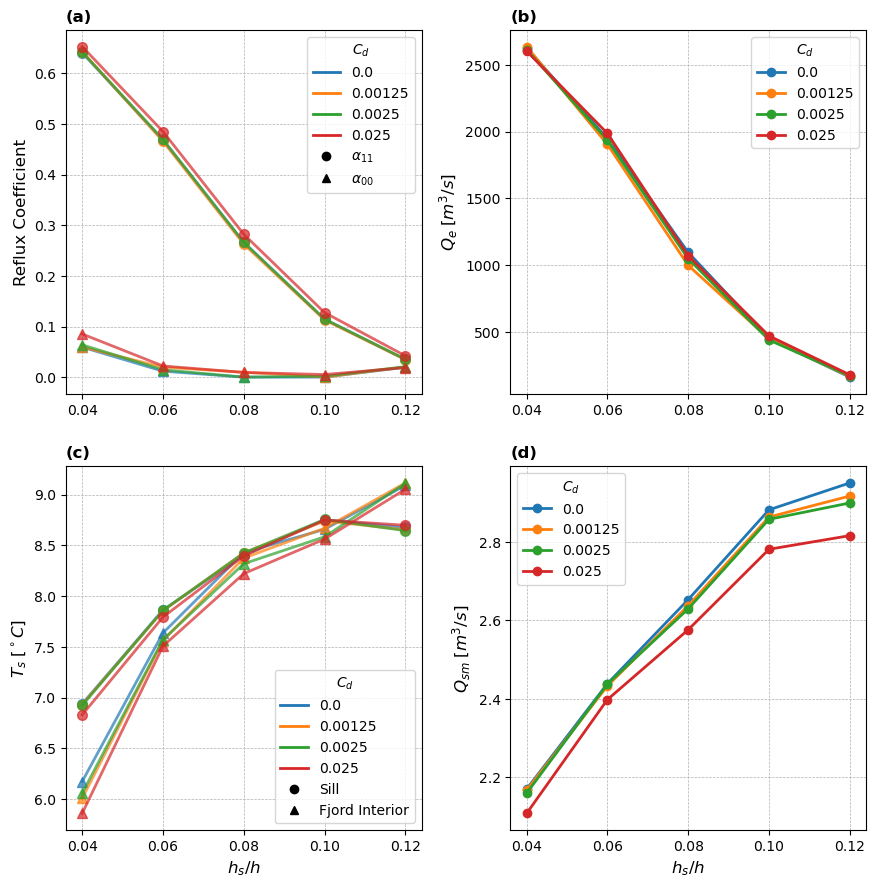

In [8]:
# 3_Plot for Cd cases
Id = np.array([1, 2, 3, 4])
Cd = np.array([0e-3, 1.25e-3, 2.5e-3, 2.5e-2])

fig3 = plt.figure(figsize=(10,10))
#fig1.tight_layout()
#plt.grid(linestyle='--', linewidth=0.5)    
ax1 = fig3.add_subplot(221)
ax2 = fig3.add_subplot(222)
ax3 = fig3.add_subplot(223)
ax4 = fig3.add_subplot(224)


from matplotlib.legend_handler import HandlerBase


# class AnyObjectHandler(HandlerBase):
#     def create_artists(self, legend, orig_handle,
#                        x0, y0, width, height, fontsize, trans):
#         l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
#                            linestyle=orig_handle[1],color=orig_handle[0])
#         l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
#                            color=orig_handle[0])
#         return [l1, l2]
    



for i in range(len(Cd)):
    
    file1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Cd_comp/Cd_' + str(format(Id[i],'03d')) + '.nc')
    hsr = file1.hsr.data
    alp11 = file1.alpha11.data
    alp11[alp11<0] = 0
    alp00 = file1.alpha00.data
    Ts_f = file1.Ts_fjord.data
    Ts_s = file1.Ts_sill.data
    Qsm = file1.Qsm.data   
    Qe = file1.Qe.data

    # Subplot of reflux coefficients
    if Id[i] == 1:
        l1,l2 = ax1.plot(hsr,alp00,'o-', hsr,alp11,'^-', ms=7, alpha=0.7, color='#1f77b4',lw=2)
    #ax1.set_ylim(0,.7)
        
    elif Id[i] == 2:
        
        l3,l4 = ax1.plot(hsr,alp00,'o-',hsr,alp11,'^-', ms=7, alpha=0.7, color='#ff7f0e',lw=2)
        
    elif Id[i] == 3:
        
        l5,l6 = ax1.plot(hsr,alp00,'o-',hsr,alp11,'^-', ms=7, alpha=0.7, color='#2ca02c',lw=2)
    
    else:
        
        l7,l8 = ax1.plot(hsr,alp00,'o-',hsr,alp11,'^-', ms=7, alpha=0.7, color='#d62728',lw=2)
    
#     ax1.legend((l1,l2,l3,l4,l5,l6,l7,l8),('100 $T_S$','100 $T_S2$','250 $T_S1$','250 $T_S2$','500 $T_S1$','500 $T_S2$','1000 $T_S1$','1000 $T_S2$'),
#                title=r'$Q_{sg}\;[m^3/s]$', loc='best', fontsize=12)



#     #Plot analytic solution
#     ax1.plot(hsr,alp11,'o-',lw=2,label=str(Qsg[i]))

#     #Plot simulation
#     ax1.plot(hsr,alp00,'^-',lw=2,label=str(Qsg[i]))

    
#     #Get artists and labels for legend and chose which ones to display
#     handles, labels = ax1.get_legend_handles_labels()
#     display = (0,1,2,3,4)

#     #Create custom artists
    
#     simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
#     anyArtist = plt.Line2D((0,1),(0,0), color='k', marker='^', linestyle='')

#     #Create legend from custom artist/label lists
#     ax1.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
#           [label for i,label in enumerate(labels) if i in display]+['Simulation', 'Analytic'], title=r'$Q_{sg}\;[m^3/s]$',loc='best', fontsize=12)
    
    #line = Line2D([0,1],[0,1],linestyle='-', color='r')
    line1 = plt.Line2D((0,1),(0,0), color='#1f77b4', lw=2, linestyle='-')
    line2 = plt.Line2D((0,1),(0,0), color='#ff7f0e', lw=2, linestyle='-')
    line3 = plt.Line2D((0,1),(0,0), color='#2ca02c', lw=2, linestyle='-')
    line4 = plt.Line2D((0,1),(0,0), color='#d62728', lw=2, linestyle='-')
    marker1 = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
    marker2 = plt.Line2D((0,1),(0,0), color='k', marker='^', linestyle='')    
    
    ax1.legend([line1,line2,line3,line4,marker1,marker2],[str(Cd[0]),str(Cd[1]),str(Cd[2]),str(Cd[3]),r'$\alpha_{11}$', r'$\alpha_{00}$'],
              title=r'$C_d$',loc='best', fontsize=10)

    ax1.grid(linestyle='--', linewidth=0.5)
    ax1.set_ylabel(r'Reflux Coefficient',size = 12)
    #ax1.xaxis.set_visible(False)
    ax1.set_title(r'(a)', loc='left', size=12, weight='bold')

    
    # Subplot of entrainment flux Qe
    ax2.plot(hsr,Qe,'o-',lw=2,label=str(Cd[i]))
    #ax2.set_ylim(0,4500)
    ax2.legend(title=r'$C_d$',loc='best', fontsize=10)
    ax2.grid(linestyle='--', linewidth=0.5)
    ax2.set_ylabel(r'$Q_e\;[m^3/s]$',size = 12)
    #ax2.xaxis.set_visible(False)
    ax2.set_title(r'(b)', loc='left', size=12, weight='bold')
       
    
    # Subplot of deep-layer temperature Ts
    if Id[i] == 1:
           
        ax3.plot(hsr,Ts_s,'o-', hsr,Ts_f,'^-', ms=7, alpha=0.7, color='#1f77b4',lw=2)
    #ax1.set_ylim(0,.7)
        
    elif Id[i] == 2:
        
        ax3.plot(hsr,Ts_s,'o-',hsr,Ts_f,'^-', ms=7, alpha=0.7, color='#ff7f0e',lw=2)
        
    elif Id[i] == 3:
        
        ax3.plot(hsr,Ts_s,'o-',hsr,Ts_f,'^-', ms=7, alpha=0.7, color='#2ca02c',lw=2)
    
    else:
        
        ax3.plot(hsr,Ts_s,'o-',hsr,Ts_f,'^-', ms=7, alpha=0.7, color='#d62728',lw=2)   
    
#     ax3.plot(hsr,Ts_s,'o-',lw=2,label=r'$Q_{sg}$')
#     ax3.plot(hsr,Ts_f,'^-',lw=2,label=r'$Q_{sg}$')

    #ax3.set_ylim(0,.7)
    #ax3.legend(loc='best', fontsize=12)
    ax3.legend([line1,line2,line3,line4,marker1,marker2],[str(Cd[0]),str(Cd[1]),str(Cd[2]),str(Cd[3]),'Sill', 'Fjord Interior'],
              title=r'$C_d$',loc='best', fontsize=10)
    
    ax3.grid(linestyle='--', linewidth=0.5)
    ax3.set_ylabel(r'$T_s\;[^\circ{C}]$',size = 12)
    ax3.set_xlabel(r'$h_s/h$', size = 12)
    ax3.set_title(r'(c)', loc='left', size=12, weight='bold')    
    
    
    # Subplot of submarine melting Qsm
    ax4.plot(hsr,Qsm,'o-',lw=2,label=str(Cd[i]))
    #ax4.set_ylim(0,4500)
    ax4.legend(title=r'$C_d$',loc='best', fontsize=10)
    ax4.grid(linestyle='--', linewidth=0.5)
    ax4.set_ylabel(r'$Q_{sm}\;[m^3/s]$',size = 12)
    ax4.set_xlabel(r'$h_s/h$', size = 12)
    ax4.set_title(r'(d)', loc='left', size=12, weight='bold')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.2)
plt.show()

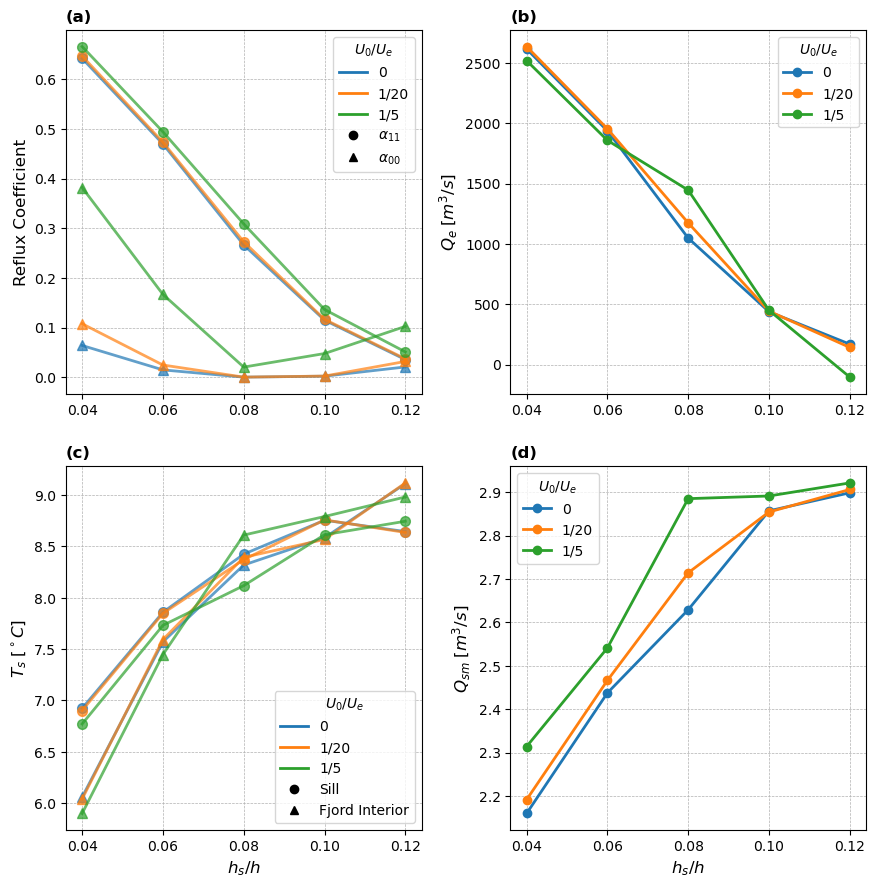

In [2]:
# 4_Plot for Tide cases
Id = np.array([0, 1, 3])
Ue = 0.20 # Exchange velocity
U0 = np.array([0, 0.01, 0.04]) # Tidal amplitude
Ur = ['0', '1/20', '1/5']

fig4 = plt.figure(figsize=(10,10))
#fig1.tight_layout()
#plt.grid(linestyle='--', linewidth=0.5)    
ax1 = fig4.add_subplot(221)
ax2 = fig4.add_subplot(222)
ax3 = fig4.add_subplot(223)
ax4 = fig4.add_subplot(224)


from matplotlib.legend_handler import HandlerBase


# class AnyObjectHandler(HandlerBase):
#     def create_artists(self, legend, orig_handle,
#                        x0, y0, width, height, fontsize, trans):
#         l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
#                            linestyle=orig_handle[1],color=orig_handle[0])
#         l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
#                            color=orig_handle[0])
#         return [l1, l2]
    



for i in range(len(Ur)):
    
    file1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Tide_comp/Tide_' + str(format(Id[i],'03d')) + '.nc')
    hsr = file1.hsr.data
    alp11 = file1.alpha11.data
    alp11[alp11<0] = 0
    alp00 = file1.alpha00.data
    Ts_f = file1.Ts_fjord.data
    Ts_s = file1.Ts_sill.data
    Qsm = file1.Qsm.data   
    Qe = file1.Qe.data

    # Subplot of reflux coefficients
    if Id[i] == 0:
        l1,l2 = ax1.plot(hsr,alp00,'o-', hsr,alp11,'^-', ms=7, alpha=0.7, color='#1f77b4',lw=2)
    #ax1.set_ylim(0,.7)
        
    elif Id[i] == 1:
        
        l3,l4 = ax1.plot(hsr,alp00,'o-',hsr,alp11,'^-', ms=7, alpha=0.7, color='#ff7f0e',lw=2)
        
    elif Id[i] == 3:
        
        l5,l6 = ax1.plot(hsr,alp00,'o-',hsr,alp11,'^-', ms=7, alpha=0.7, color='#2ca02c',lw=2)
    
    else:
        
        l7,l8 = ax1.plot(hsr,alp00,'o-',hsr,alp11,'^-', ms=7, alpha=0.7, color='#d62728',lw=2)
    
#     ax1.legend((l1,l2,l3,l4,l5,l6,l7,l8),('100 $T_S$','100 $T_S2$','250 $T_S1$','250 $T_S2$','500 $T_S1$','500 $T_S2$','1000 $T_S1$','1000 $T_S2$'),
#                title=r'$Q_{sg}\;[m^3/s]$', loc='best', fontsize=12)



#     #Plot analytic solution
#     ax1.plot(hsr,alp11,'o-',lw=2,label=str(Qsg[i]))

#     #Plot simulation
#     ax1.plot(hsr,alp00,'^-',lw=2,label=str(Qsg[i]))

    
#     #Get artists and labels for legend and chose which ones to display
#     handles, labels = ax1.get_legend_handles_labels()
#     display = (0,1,2,3,4)

#     #Create custom artists
    
#     simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
#     anyArtist = plt.Line2D((0,1),(0,0), color='k', marker='^', linestyle='')

#     #Create legend from custom artist/label lists
#     ax1.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
#           [label for i,label in enumerate(labels) if i in display]+['Simulation', 'Analytic'], title=r'$Q_{sg}\;[m^3/s]$',loc='best', fontsize=12)
    
    #line = Line2D([0,1],[0,1],linestyle='-', color='r')
    line1 = plt.Line2D((0,1),(0,0), color='#1f77b4', lw=2, linestyle='-')
    line2 = plt.Line2D((0,1),(0,0), color='#ff7f0e', lw=2, linestyle='-')
    line3 = plt.Line2D((0,1),(0,0), color='#2ca02c', lw=2, linestyle='-')
    line4 = plt.Line2D((0,1),(0,0), color='#d62728', lw=2, linestyle='-')
    marker1 = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
    marker2 = plt.Line2D((0,1),(0,0), color='k', marker='^', linestyle='')    
    
    ax1.legend([line1,line2,line3,marker1,marker2],[str(Ur[0]),str(Ur[1]),str(Ur[2]),r'$\alpha_{11}$', r'$\alpha_{00}$'],
              title=r'$U_0/U_e$',loc='best', fontsize=10)

    ax1.grid(linestyle='--', linewidth=0.5)
    ax1.set_ylabel(r'Reflux Coefficient',size = 12)
    #ax1.xaxis.set_visible(False)
    ax1.set_title(r'(a)', loc='left', size=12, weight='bold')

    
    # Subplot of entrainment flux Qe
    ax2.plot(hsr,Qe,'o-',lw=2,label=str(Ur[i]))
    #ax2.set_ylim(0,4500)
    ax2.legend(title=r'$U_0/U_e$',loc='best', fontsize=10)
    ax2.grid(linestyle='--', linewidth=0.5)
    ax2.set_ylabel(r'$Q_e\;[m^3/s]$',size = 12)
    #ax2.xaxis.set_visible(False)
    ax2.set_title(r'(b)', loc='left', size=12, weight='bold')
       
    
    # Subplot of deep-layer temperature Ts
    if Id[i] == 0:
           
        ax3.plot(hsr,Ts_s,'o-', hsr,Ts_f,'^-', ms=7, alpha=0.7, color='#1f77b4',lw=2)
    #ax1.set_ylim(0,.7)
        
    elif Id[i] == 1:
        
        ax3.plot(hsr,Ts_s,'o-',hsr,Ts_f,'^-', ms=7, alpha=0.7, color='#ff7f0e',lw=2)
        
    elif Id[i] == 3:
        
        ax3.plot(hsr,Ts_s,'o-',hsr,Ts_f,'^-', ms=7, alpha=0.7, color='#2ca02c',lw=2)
    
    else:
        
        ax3.plot(hsr,Ts_s,'o-',hsr,Ts_f,'^-', ms=7, alpha=0.7, color='#d62728',lw=2)   
    
#     ax3.plot(hsr,Ts_s,'o-',lw=2,label=r'$Q_{sg}$')
#     ax3.plot(hsr,Ts_f,'^-',lw=2,label=r'$Q_{sg}$')

    #ax3.set_ylim(0,.7)
    #ax3.legend(loc='best', fontsize=12)
    ax3.legend([line1,line2,line3,marker1,marker2],[str(Ur[0]),str(Ur[1]),str(Ur[2]),'Sill', 'Fjord Interior'],
              title=r'$U_0/U_e$',loc='best', fontsize=10)
    
    ax3.grid(linestyle='--', linewidth=0.5)
    ax3.set_ylabel(r'$T_s\;[^\circ{C}]$',size = 12)
    ax3.set_xlabel(r'$h_s/h$', size = 12)
    ax3.set_title(r'(c)', loc='left', size=12, weight='bold')    
    
    
    # Subplot of submarine melting Qsm
    ax4.plot(hsr,Qsm,'o-',lw=2,label=str(Ur[i]))
    #ax4.set_ylim(0,4500)
    ax4.legend(title=r'$U_0/U_e$',loc='best', fontsize=10)
    ax4.grid(linestyle='--', linewidth=0.5)
    ax4.set_ylabel(r'$Q_{sm}\;[m^3/s]$',size = 12)
    ax4.set_xlabel(r'$h_s/h$', size = 12)
    ax4.set_title(r'(d)', loc='left', size=12, weight='bold')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.2)
plt.show()

In [18]:
#Ts_f
from fractions import Fraction
from sympy import Rational
A = Fraction(1,3)
B = Fraction(1.5,3)
print(A,B)

ModuleNotFoundError: No module named 'sympy'

In [3]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/Comp_cases/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

#fig1.savefig(fig_path + '/Qsg_comp.png', dpi=200, bbox_inches='tight')
#fig2.savefig(fig_path + '/Strat_comp.png', dpi=200, bbox_inches='tight')
#fig3.savefig(fig_path + '/Cd_comp.png', dpi=200, bbox_inches='tight')
fig4.savefig(fig_path + '/Tide_comp.png', dpi=200, bbox_inches='tight')